In [1]:
!pip install wandb

In [8]:
import wandb
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import wandb
from tqdm import tqdm
import time

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nipkha21 (nipkha21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [46]:
from data_utils import load_split_data
from models import AdvancedMLP, get_model
from training_utils import ModelTrainer, get_optimizer, get_scheduler
from evaluation import ModelEvaluator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
class MLPFacialExpressionDataset(Dataset):
    def __init__(self, data, normalization='standard', augment=False, is_test=False):
        self.data = data
        self.normalization = normalization
        self.augment = augment
        self.is_test = is_test

        if normalization == 'global_stats':
            self._compute_global_stats()

    def _compute_global_stats(self):
        all_pixels = []
        sample_size = min(1000, len(self.data))
        for i in range(sample_size):
            pixels = np.array([int(p) for p in self.data.iloc[i]['pixels'].split()])
            all_pixels.extend(pixels)

        all_pixels = np.array(all_pixels)
        self.global_mean = np.mean(all_pixels)
        self.global_std = np.std(all_pixels)

    def _apply_augmentation(self, image):
        if not self.augment or np.random.random() > 0.5:
            return image

        img_2d = image.reshape(48, 48)

        if np.random.random() > 0.7:
            noise = np.random.normal(0, 0.01, img_2d.shape)
            img_2d = np.clip(img_2d + noise, 0, 1)

        if np.random.random() > 0.7:
            brightness_factor = np.random.uniform(0.8, 1.2)
            img_2d = np.clip(img_2d * brightness_factor, 0, 1)

        if np.random.random() > 0.5:
            img_2d = np.fliplr(img_2d)

        return img_2d.flatten()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        image = np.array([int(pixel) for pixel in pixels.split()], dtype=np.float32)

        if self.normalization == 'standard':
            image = image / 255.0
        elif self.normalization == 'centered':
            image = (image / 255.0) * 2 - 1
        elif self.normalization == 'minmax':
            image = (image - image.min()) / (image.max() - image.min())
        elif self.normalization == 'zscore':
            image = (image - image.mean()) / image.std()
        elif self.normalization == 'global_stats':
            image = (image - self.global_mean) / self.global_std

        if self.augment and not self.is_test:
            image = self._apply_augmentation(image)

        image = torch.FloatTensor(image)

        if self.is_test:
            return image
        else:
            emotion = int(self.data.iloc[idx]['emotion'])
            return image, emotion

In [11]:
class AdvancedTrainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer,
                 scheduler=None, device='cuda', experiment_name='experiment', run_name='run'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

        wandb.init(
            project="facial-expression-recognition",
            group=experiment_name,
            name=run_name,
            config={
                "data_split_method": "predefined_stratified",
                "train_samples": len(train_loader.dataset),
                "val_samples": len(val_loader.dataset),
                "split_random_state": 42
            },
            reinit=True
        )
        wandb.watch(self.model, log='all', log_freq=100)

        self.history = {
            'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
            'learning_rates': [], 'epoch_times': []
        }
        self.best_val_acc = 0.0
        self.best_model_state = None

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc="Training")
        for batch_idx, (data, targets) in enumerate(pbar):
            data, targets = data.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(data)
            loss = self.criterion(outputs, targets)

            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc

    def validate_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for data, targets in tqdm(self.val_loader, desc="Validation"):
                data, targets = data.to(self.device), targets.to(self.device)

                outputs = self.model(data)
                loss = self.criterion(outputs, targets)

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc, np.array(all_predictions), np.array(all_targets)

    def train(self, epochs, early_stopping_patience=10):
        print(f"Starting training for {epochs} epochs...")

        patience_counter = 0

        for epoch in range(epochs):
            epoch_start = time.time()

            train_loss, train_acc = self.train_epoch()

            val_loss, val_acc, val_preds, val_targets = self.validate_epoch()

            current_lr = self.optimizer.param_groups[0]['lr']
            if self.scheduler:
                if isinstance(self.scheduler, ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()

            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.best_model_state = self.model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1

            epoch_time = time.time() - epoch_start

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rates'].append(current_lr)
            self.history['epoch_times'].append(epoch_time)

            loss_gap = val_loss - train_loss
            acc_gap = train_acc - val_acc

            log_dict = {
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_accuracy': train_acc,
                'val_loss': val_loss,
                'val_accuracy': val_acc,
                'learning_rate': current_lr,
                'epoch_time': epoch_time,
                'loss_gap': loss_gap,
                'accuracy_gap': acc_gap,
                'overfitting_score': loss_gap + (acc_gap / 100),
                'best_val_accuracy': self.best_val_acc
            }

            if (epoch + 1) % 10 == 0:
                emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
                log_dict['confusion_matrix'] = wandb.plot.confusion_matrix(
                    probs=None, y_true=val_targets, preds=val_preds,
                    class_names=list(emotion_map.values())
                )

            wandb.log(log_dict)

            print(f"Epoch {epoch+1}/{epochs}:")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            print(f"  LR: {current_lr:.6f}, Time: {epoch_time:.2f}s")
            print(f"  Overfitting Score: {loss_gap + (acc_gap / 100):.4f}")
            print("-" * 50)

            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        if self.best_model_state:
            self.model.load_state_dict(self.best_model_state)
            print(f"Loaded best model with validation accuracy: {self.best_val_acc:.2f}%")

        return self.history

In [12]:
wandb.login()

print("=== LOADING PRE-SPLIT DATA ===")

train_df, val_df, test_df = load_split_data('drive/MyDrive/data')

emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

=== LOADING PRE-SPLIT DATA ===


In [14]:
print("=== ACTIVATION FUNCTION EXPERIMENTS ===")

class FlexibleMLP(nn.Module):
    """MLP with configurable activation function for activation experiments"""
    def __init__(self, input_size=2304, hidden_sizes=[512, 256], num_classes=7,
                 dropout_rate=0.3, use_batch_norm=True, activation='relu'):
        super(FlexibleMLP, self).__init__()

        self.use_batch_norm = use_batch_norm
        self.activation_fn = self._get_activation(activation)

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(self.activation_fn)
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, num_classes))

        self.layers = nn.Sequential(*layers)
        self._initialize_weights()

    def _get_activation(self, activation):
        activations = {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(0.01),
            'elu': nn.ELU(),
            'gelu': nn.GELU(),
            'swish': nn.SiLU(),
            'tanh': nn.Tanh()
        }
        return activations.get(activation, nn.ReLU())

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

activation_functions = ['relu', 'leaky_relu', 'elu', 'gelu', 'swish', 'tanh']
activation_results = {}

for activation in activation_functions:
    print(f"\nTesting activation function: {activation}")

    train_dataset = MLPFacialExpressionDataset(train_df, normalization='standard')
    val_dataset = MLPFacialExpressionDataset(val_df, normalization='standard')

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model = FlexibleMLP(
        input_size=2304,
        hidden_sizes=[512, 256],
        num_classes=7,
        dropout_rate=0.3,
        use_batch_norm=True,
        activation=activation
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    trainer = AdvancedTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        experiment_name="Advanced_MLP_Training",
        run_name=f"Activation_{activation}"
    )

    history = trainer.train(epochs=10, early_stopping_patience=5)

    activation_results[activation] = {
        'best_val_acc': trainer.best_val_acc,
        'final_train_acc': history['train_acc'][-1],
        'final_val_acc': history['val_acc'][-1],
        'convergence_speed': len(history['train_acc'])
    }

    wandb.finish()

    print(f"Best validation accuracy: {trainer.best_val_acc:.2f}%")

print("\n=== ACTIVATION FUNCTION ANALYSIS ===")
best_activation = max(activation_results.keys(), key=lambda x: activation_results[x]['best_val_acc'])
print(f"Best activation function: {best_activation}")

for activation, results in activation_results.items():
    print(f"{activation}: {results['best_val_acc']:.2f}%")

=== ACTIVATION FUNCTION EXPERIMENTS ===

Testing activation function: relu


accuracy_gap,▁
best_val_accuracy,▁
epoch,▁
epoch_time,▁
learning_rate,▁
loss_gap,▁
overfitting_score,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁


Starting training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:02<00:00, 26.47it/s]


Epoch 1/10:
  Train Loss: 1.8216, Train Acc: 29.67%
  Val Loss: 1.6497, Val Acc: 35.01%
  LR: 0.001000, Time: 17.79s
  Overfitting Score: -0.2252
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 16.54it/s]


Epoch 2/10:
  Train Loss: 1.6569, Train Acc: 35.23%
  Val Loss: 1.6064, Val Acc: 36.59%
  LR: 0.001000, Time: 20.25s
  Overfitting Score: -0.0642
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.88it/s]


Epoch 3/10:
  Train Loss: 1.5935, Train Acc: 37.89%
  Val Loss: 1.6470, Val Acc: 34.27%
  LR: 0.001000, Time: 17.98s
  Overfitting Score: 0.0898
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.32it/s]


Epoch 4/10:
  Train Loss: 1.5449, Train Acc: 39.78%
  Val Loss: 1.6158, Val Acc: 36.71%
  LR: 0.001000, Time: 18.56s
  Overfitting Score: 0.1016
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 16.30it/s]


Epoch 5/10:
  Train Loss: 1.5064, Train Acc: 41.76%
  Val Loss: 1.6335, Val Acc: 36.73%
  LR: 0.001000, Time: 19.90s
  Overfitting Score: 0.1773
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 26.02it/s]


Epoch 6/10:
  Train Loss: 1.4796, Train Acc: 42.74%
  Val Loss: 1.6713, Val Acc: 37.59%
  LR: 0.001000, Time: 18.35s
  Overfitting Score: 0.2432
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.94it/s]


Epoch 7/10:
  Train Loss: 1.4463, Train Acc: 44.08%
  Val Loss: 1.6715, Val Acc: 35.55%
  LR: 0.001000, Time: 18.30s
  Overfitting Score: 0.3106
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 18.62it/s]


Epoch 8/10:
  Train Loss: 1.4078, Train Acc: 45.56%
  Val Loss: 1.6057, Val Acc: 35.92%
  LR: 0.001000, Time: 19.82s
  Overfitting Score: 0.2944
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.60it/s]


Epoch 9/10:
  Train Loss: 1.3792, Train Acc: 46.98%
  Val Loss: 1.5582, Val Acc: 38.89%
  LR: 0.001000, Time: 18.42s
  Overfitting Score: 0.2598
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.33it/s]


Epoch 10/10:
  Train Loss: 1.3521, Train Acc: 48.33%
  Val Loss: 1.7581, Val Acc: 31.90%
  LR: 0.001000, Time: 18.20s
  Overfitting Score: 0.5702
--------------------------------------------------
Loaded best model with validation accuracy: 38.89%


accuracy_gap,▁▂▄▄▄▄▅▆▅█
best_val_accuracy,▁▄▄▄▄▆▆▆██
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▁█▂▃▇▃▂▇▃▂
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▂▄▄▅▅▆▅▅█
overfitting_score,▁▂▄▄▅▅▆▆▅█
train_accuracy,▁▃▄▅▆▆▆▇▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▄▆▃▆▆▇▅▅█▁
val_loss,▄▃▄▃▄▅▅▃▁█


Best validation accuracy: 38.89%

Testing activation function: leaky_relu


Starting training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:02<00:00, 26.27it/s]


Epoch 1/10:
  Train Loss: 1.8351, Train Acc: 29.18%
  Val Loss: 1.6687, Val Acc: 33.55%
  LR: 0.001000, Time: 18.10s
  Overfitting Score: -0.2102
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 26.14it/s]


Epoch 2/10:
  Train Loss: 1.6558, Train Acc: 35.17%
  Val Loss: 1.6237, Val Acc: 35.83%
  LR: 0.001000, Time: 18.08s
  Overfitting Score: -0.0387
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 15.79it/s]


Epoch 3/10:
  Train Loss: 1.5915, Train Acc: 37.58%
  Val Loss: 1.5886, Val Acc: 37.87%
  LR: 0.001000, Time: 19.79s
  Overfitting Score: -0.0058
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.69it/s]


Epoch 4/10:
  Train Loss: 1.5469, Train Acc: 39.67%
  Val Loss: 1.6073, Val Acc: 37.17%
  LR: 0.001000, Time: 18.15s
  Overfitting Score: 0.0854
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.56it/s]


Epoch 5/10:
  Train Loss: 1.5109, Train Acc: 41.18%
  Val Loss: 1.5589, Val Acc: 39.15%
  LR: 0.001000, Time: 18.15s
  Overfitting Score: 0.0683
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 15.88it/s]


Epoch 6/10:
  Train Loss: 1.4778, Train Acc: 43.10%
  Val Loss: 1.6243, Val Acc: 36.61%
  LR: 0.001000, Time: 19.83s
  Overfitting Score: 0.2113
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 26.01it/s]


Epoch 7/10:
  Train Loss: 1.4488, Train Acc: 43.99%
  Val Loss: 1.5653, Val Acc: 39.80%
  LR: 0.001000, Time: 18.17s
  Overfitting Score: 0.1585
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.94it/s]


Epoch 8/10:
  Train Loss: 1.4199, Train Acc: 45.16%
  Val Loss: 1.5913, Val Acc: 38.57%
  LR: 0.001000, Time: 18.31s
  Overfitting Score: 0.2373
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 16.28it/s]


Epoch 9/10:
  Train Loss: 1.3893, Train Acc: 46.51%
  Val Loss: 1.5681, Val Acc: 39.38%
  LR: 0.001000, Time: 19.95s
  Overfitting Score: 0.2501
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.50it/s]


Epoch 10/10:
  Train Loss: 1.3570, Train Acc: 48.06%
  Val Loss: 1.6051, Val Acc: 37.96%
  LR: 0.001000, Time: 18.29s
  Overfitting Score: 0.3491
--------------------------------------------------
Loaded best model with validation accuracy: 39.80%


accuracy_gap,▁▃▃▄▄▆▅▆▇█
best_val_accuracy,▁▄▆▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▁▁▇▁▁█▁▂█▂
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▃▄▅▅▆▆▇▇█
overfitting_score,▁▃▄▅▄▆▆▇▇█
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▅▄▄▃▃▂▂▁▁
val_accuracy,▁▄▆▅▇▄█▇█▆
val_loss,█▅▃▄▁▅▁▃▂▄


Best validation accuracy: 39.80%

Testing activation function: elu


Starting training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:03<00:00, 18.17it/s]


Epoch 1/10:
  Train Loss: 1.8714, Train Acc: 29.14%
  Val Loss: 1.6835, Val Acc: 33.99%
  LR: 0.001000, Time: 19.30s
  Overfitting Score: -0.2364
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.60it/s]


Epoch 2/10:
  Train Loss: 1.7023, Train Acc: 33.79%
  Val Loss: 1.6229, Val Acc: 36.43%
  LR: 0.001000, Time: 18.93s
  Overfitting Score: -0.1059
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.75it/s]


Epoch 3/10:
  Train Loss: 1.6409, Train Acc: 36.06%
  Val Loss: 1.6375, Val Acc: 36.43%
  LR: 0.001000, Time: 18.78s
  Overfitting Score: -0.0072
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 15.78it/s]


Epoch 4/10:
  Train Loss: 1.6068, Train Acc: 37.66%
  Val Loss: 1.6188, Val Acc: 36.59%
  LR: 0.001000, Time: 19.87s
  Overfitting Score: 0.0227
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.50it/s]


Epoch 5/10:
  Train Loss: 1.5771, Train Acc: 38.53%
  Val Loss: 1.6014, Val Acc: 37.82%
  LR: 0.001000, Time: 18.43s
  Overfitting Score: 0.0315
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.92it/s]


Epoch 6/10:
  Train Loss: 1.5552, Train Acc: 39.35%
  Val Loss: 1.6102, Val Acc: 37.31%
  LR: 0.001000, Time: 18.34s
  Overfitting Score: 0.0754
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 16.88it/s]


Epoch 7/10:
  Train Loss: 1.5361, Train Acc: 40.39%
  Val Loss: 1.6283, Val Acc: 37.61%
  LR: 0.001000, Time: 19.97s
  Overfitting Score: 0.1200
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 24.87it/s]


Epoch 8/10:
  Train Loss: 1.5109, Train Acc: 41.06%
  Val Loss: 1.6474, Val Acc: 36.71%
  LR: 0.001000, Time: 18.50s
  Overfitting Score: 0.1801
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.26it/s]


Epoch 9/10:
  Train Loss: 1.4985, Train Acc: 41.78%
  Val Loss: 1.6439, Val Acc: 35.73%
  LR: 0.001000, Time: 18.32s
  Overfitting Score: 0.2058
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 19.20it/s]


Epoch 10/10:
  Train Loss: 1.4791, Train Acc: 42.49%
  Val Loss: 1.8536, Val Acc: 29.44%
  LR: 0.001000, Time: 20.08s
  Overfitting Score: 0.5050
--------------------------------------------------
Early stopping triggered at epoch 10
Loaded best model with validation accuracy: 37.82%


accuracy_gap,▁▂▃▃▃▄▄▅▅█
best_val_accuracy,▁▅▅▆██████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▅▃▃▇▁▁█▂▁█
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▂▃▃▄▄▄▅▅█
overfitting_score,▁▂▃▃▄▄▄▅▅█
train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▅▇▇▇███▇▆▁
val_loss,▃▂▂▁▁▁▂▂▂█


Best validation accuracy: 37.82%

Testing activation function: gelu


Starting training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.83it/s]


Epoch 1/10:
  Train Loss: 1.7997, Train Acc: 30.35%
  Val Loss: 1.6261, Val Acc: 36.10%
  LR: 0.001000, Time: 18.20s
  Overfitting Score: -0.2312
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 15.60it/s]


Epoch 2/10:
  Train Loss: 1.6340, Train Acc: 36.10%
  Val Loss: 1.6271, Val Acc: 36.36%
  LR: 0.001000, Time: 20.05s
  Overfitting Score: -0.0095
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.49it/s]


Epoch 3/10:
  Train Loss: 1.5676, Train Acc: 39.18%
  Val Loss: 1.6340, Val Acc: 36.17%
  LR: 0.001000, Time: 18.35s
  Overfitting Score: 0.0964
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.95it/s]


Epoch 4/10:
  Train Loss: 1.5144, Train Acc: 41.07%
  Val Loss: 1.6448, Val Acc: 33.41%
  LR: 0.001000, Time: 18.51s
  Overfitting Score: 0.2070
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 17.22it/s]


Epoch 5/10:
  Train Loss: 1.4753, Train Acc: 42.82%
  Val Loss: 1.5663, Val Acc: 39.08%
  LR: 0.001000, Time: 20.23s
  Overfitting Score: 0.1285
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.81it/s]


Epoch 6/10:
  Train Loss: 1.4318, Train Acc: 44.41%
  Val Loss: 1.5954, Val Acc: 38.15%
  LR: 0.001000, Time: 18.32s
  Overfitting Score: 0.2262
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.61it/s]


Epoch 7/10:
  Train Loss: 1.3932, Train Acc: 45.97%
  Val Loss: 1.5572, Val Acc: 39.84%
  LR: 0.001000, Time: 18.36s
  Overfitting Score: 0.2253
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 19.50it/s]


Epoch 8/10:
  Train Loss: 1.3610, Train Acc: 47.84%
  Val Loss: 1.5687, Val Acc: 39.68%
  LR: 0.001000, Time: 20.02s
  Overfitting Score: 0.2894
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.57it/s]


Epoch 9/10:
  Train Loss: 1.3285, Train Acc: 49.24%
  Val Loss: 1.5521, Val Acc: 40.31%
  LR: 0.001000, Time: 18.32s
  Overfitting Score: 0.3129
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 24.73it/s]

Epoch 10/10:
  Train Loss: 1.2844, Train Acc: 51.03%
  Val Loss: 1.5847, Val Acc: 39.28%
  LR: 0.001000, Time: 18.45s
  Overfitting Score: 0.4178
--------------------------------------------------
Loaded best model with validation accuracy: 40.31%


accuracy_gap,▁▃▅▆▅▆▆▇▇█
best_val_accuracy,▁▁▁▁▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▁▇▁▂█▁▂▇▁▂
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▃▅▅▅▆▆▇▇█
overfitting_score,▁▃▅▆▅▆▆▇▇█
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▄▄▃▂▂▂▁
val_accuracy,▄▄▄▁▇▆█▇█▇
val_loss,▇▇▇█▂▄▁▂▁▃


Best validation accuracy: 40.31%

Testing activation function: swish


Starting training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:02<00:00, 26.17it/s]


Epoch 1/10:
  Train Loss: 1.7862, Train Acc: 30.97%
  Val Loss: 1.6525, Val Acc: 34.55%
  LR: 0.001000, Time: 18.44s
  Overfitting Score: -0.1694
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.70it/s]


Epoch 2/10:
  Train Loss: 1.6470, Train Acc: 35.78%
  Val Loss: 1.6155, Val Acc: 37.31%
  LR: 0.001000, Time: 18.48s
  Overfitting Score: -0.0468
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 17.62it/s]


Epoch 3/10:
  Train Loss: 1.5804, Train Acc: 38.42%
  Val Loss: 1.6146, Val Acc: 37.13%
  LR: 0.001000, Time: 19.96s
  Overfitting Score: 0.0471
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.38it/s]


Epoch 4/10:
  Train Loss: 1.5384, Train Acc: 39.76%
  Val Loss: 1.6137, Val Acc: 36.87%
  LR: 0.001000, Time: 18.44s
  Overfitting Score: 0.1041
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.78it/s]


Epoch 5/10:
  Train Loss: 1.5036, Train Acc: 41.52%
  Val Loss: 1.7222, Val Acc: 29.70%
  LR: 0.001000, Time: 18.31s
  Overfitting Score: 0.3369
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 19.95it/s]


Epoch 6/10:
  Train Loss: 1.4651, Train Acc: 43.08%
  Val Loss: 1.6979, Val Acc: 31.14%
  LR: 0.001000, Time: 19.96s
  Overfitting Score: 0.3522
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 26.24it/s]

Epoch 7/10:
  Train Loss: 1.4365, Train Acc: 44.56%
  Val Loss: 1.6545, Val Acc: 36.15%
  LR: 0.001000, Time: 18.47s
  Overfitting Score: 0.3021
--------------------------------------------------
Early stopping triggered at epoch 7
Loaded best model with validation accuracy: 37.31%


accuracy_gap,▁▂▃▄██▆
best_val_accuracy,▁██████
epoch,▁▂▃▅▆▇█
epoch_time,▂▂█▂▁█▂
learning_rate,▁▁▁▁▁▁▁
loss_gap,▁▃▄▅███
overfitting_score,▁▃▄▅██▇
train_accuracy,▁▃▅▆▆▇█
train_loss,█▅▄▃▂▂▁
val_accuracy,▅███▁▂▇
val_loss,▄▁▁▁█▆▄


Best validation accuracy: 37.31%

Testing activation function: tanh


Starting training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:04<00:00, 15.88it/s]


Epoch 1/10:
  Train Loss: 1.8645, Train Acc: 28.06%
  Val Loss: 1.7226, Val Acc: 32.06%
  LR: 0.001000, Time: 20.09s
  Overfitting Score: -0.1819
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.98it/s]


Epoch 2/10:
  Train Loss: 1.7034, Train Acc: 33.52%
  Val Loss: 1.7482, Val Acc: 31.60%
  LR: 0.001000, Time: 18.36s
  Overfitting Score: 0.0639
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.54it/s]


Epoch 3/10:
  Train Loss: 1.6471, Train Acc: 35.86%
  Val Loss: 1.6438, Val Acc: 35.43%
  LR: 0.001000, Time: 18.56s
  Overfitting Score: 0.0011
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 16.30it/s]


Epoch 4/10:
  Train Loss: 1.6087, Train Acc: 37.23%
  Val Loss: 1.6412, Val Acc: 36.06%
  LR: 0.001000, Time: 20.28s
  Overfitting Score: 0.0442
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.53it/s]


Epoch 5/10:
  Train Loss: 1.5837, Train Acc: 38.18%
  Val Loss: 1.6334, Val Acc: 35.29%
  LR: 0.001000, Time: 18.44s
  Overfitting Score: 0.0786
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.73it/s]


Epoch 6/10:
  Train Loss: 1.5638, Train Acc: 39.10%
  Val Loss: 1.6201, Val Acc: 36.94%
  LR: 0.001000, Time: 18.53s
  Overfitting Score: 0.0779
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 20.07it/s]


Epoch 7/10:
  Train Loss: 1.5487, Train Acc: 40.04%
  Val Loss: 1.6411, Val Acc: 35.24%
  LR: 0.001000, Time: 20.26s
  Overfitting Score: 0.1404
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.65it/s]


Epoch 8/10:
  Train Loss: 1.5255, Train Acc: 40.33%
  Val Loss: 1.6711, Val Acc: 36.36%
  LR: 0.001000, Time: 18.68s
  Overfitting Score: 0.1854
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 21.56it/s]


Epoch 9/10:
  Train Loss: 1.5073, Train Acc: 41.88%
  Val Loss: 1.7043, Val Acc: 33.88%
  LR: 0.001000, Time: 18.95s
  Overfitting Score: 0.2770
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 24.95it/s]

Epoch 10/10:
  Train Loss: 1.4972, Train Acc: 42.15%
  Val Loss: 1.6807, Val Acc: 36.29%
  LR: 0.001000, Time: 19.64s
  Overfitting Score: 0.2421
--------------------------------------------------
Loaded best model with validation accuracy: 36.94%


accuracy_gap,▁▄▄▄▅▅▆▆█▇
best_val_accuracy,▁▁▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▇▁▂█▁▂█▂▃▆
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▅▄▅▅▅▆▇██
overfitting_score,▁▅▄▄▅▅▆▇█▇
train_accuracy,▁▄▅▆▆▆▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▂▁▆▇▆█▆▇▄▇
val_loss,▇█▂▂▂▁▂▄▆▄


Best validation accuracy: 36.94%

=== ACTIVATION FUNCTION ANALYSIS ===
Best activation function: gelu
relu: 38.89%
leaky_relu: 39.80%
elu: 37.82%
gelu: 40.31%
swish: 37.31%
tanh: 36.94%


In [23]:
print("=== OPTIMIZER COMPARISON ===")

optimizers_config = {
    'adam': {'class': optim.Adam, 'kwargs': {'lr': 0.001}},
    'sgd': {'class': optim.SGD, 'kwargs': {'lr': 0.01, 'momentum': 0.9}},
    'sgd_nesterov': {'class': optim.SGD, 'kwargs': {'lr': 0.01, 'momentum': 0.9, 'nesterov': True}},
    'rmsprop': {'class': optim.RMSprop, 'kwargs': {'lr': 0.001, 'alpha': 0.99}},
}

optimizer_results = {}

for opt_name, opt_config in optimizers_config.items():
    print(f"\nTesting optimizer: {opt_name}")

    train_dataset = MLPFacialExpressionDataset(train_df, normalization='standard')
    val_dataset = MLPFacialExpressionDataset(val_df, normalization='standard')

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model = AdvancedMLP(
        input_size=2304,
        hidden_sizes=[512, 256],
        num_classes=7,
        dropout_rate=0.3
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = opt_config['class'](model.parameters(), **opt_config['kwargs'])

    trainer = AdvancedTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        experiment_name="Advanced_MLP_Training",
        run_name=f"Optimizer_{opt_name}"
    )

    history = trainer.train(epochs=10, early_stopping_patience=7)

    optimizer_results[opt_name] = {
        'best_val_acc': trainer.best_val_acc,
        'final_train_acc': history['train_acc'][-1],
        'final_val_acc': history['val_acc'][-1],
        'training_stability': np.std(history['val_acc'][-10:])
    }

    wandb.finish()

    print(f"Best validation accuracy: {trainer.best_val_acc:.2f}%")

print("\n=== OPTIMIZER ANALYSIS ===")
best_optimizer = max(optimizer_results.keys(), key=lambda x: optimizer_results[x]['best_val_acc'])
print(f"Best optimizer: {best_optimizer}")

for opt_name, results in optimizer_results.items():
    print(f"{opt_name}: {results['best_val_acc']:.2f}% (stability: {results['training_stability']:.4f})")

=== OPTIMIZER COMPARISON ===

Testing optimizer: adam


Starting training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:02<00:00, 26.08it/s]


Epoch 1/10:
  Train Loss: 1.8295, Train Acc: 29.35%
  Val Loss: 1.6530, Val Acc: 35.18%
  LR: 0.001000, Time: 18.27s
  Overfitting Score: -0.2349
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 15.78it/s]


Epoch 2/10:
  Train Loss: 1.6597, Train Acc: 35.07%
  Val Loss: 1.6298, Val Acc: 36.92%
  LR: 0.001000, Time: 19.89s
  Overfitting Score: -0.0485
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.85it/s]


Epoch 3/10:
  Train Loss: 1.5884, Train Acc: 38.03%
  Val Loss: 1.6188, Val Acc: 36.71%
  LR: 0.001000, Time: 18.04s
  Overfitting Score: 0.0436
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.75it/s]


Epoch 4/10:
  Train Loss: 1.5430, Train Acc: 39.68%
  Val Loss: 1.6461, Val Acc: 35.41%
  LR: 0.001000, Time: 18.10s
  Overfitting Score: 0.1458
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 15.65it/s]


Epoch 5/10:
  Train Loss: 1.5031, Train Acc: 41.60%
  Val Loss: 1.5956, Val Acc: 37.59%
  LR: 0.001000, Time: 19.84s
  Overfitting Score: 0.1326
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.96it/s]


Epoch 6/10:
  Train Loss: 1.4753, Train Acc: 42.64%
  Val Loss: 1.5735, Val Acc: 38.38%
  LR: 0.001000, Time: 17.91s
  Overfitting Score: 0.1408
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 26.24it/s]


Epoch 7/10:
  Train Loss: 1.4432, Train Acc: 44.05%
  Val Loss: 1.5640, Val Acc: 39.66%
  LR: 0.001000, Time: 18.05s
  Overfitting Score: 0.1648
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 15.98it/s]


Epoch 8/10:
  Train Loss: 1.4114, Train Acc: 45.65%
  Val Loss: 1.5571, Val Acc: 39.38%
  LR: 0.001000, Time: 19.71s
  Overfitting Score: 0.2084
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.61it/s]


Epoch 9/10:
  Train Loss: 1.3862, Train Acc: 46.68%
  Val Loss: 1.5485, Val Acc: 39.61%
  LR: 0.001000, Time: 18.14s
  Overfitting Score: 0.2331
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 26.14it/s]


Epoch 10/10:
  Train Loss: 1.3605, Train Acc: 47.40%
  Val Loss: 1.5662, Val Acc: 38.94%
  LR: 0.001000, Time: 18.17s
  Overfitting Score: 0.2903
--------------------------------------------------
Loaded best model with validation accuracy: 39.66%


accuracy_gap,▁▃▅▆▆▆▆▇▇█
best_val_accuracy,▁▄▄▄▅▆████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▂█▁▂█▁▁▇▂▂
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▄▅▆▆▆▆▇▇█
overfitting_score,▁▃▅▆▆▆▆▇▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▅▄▄▃▃▂▂▁▁
val_accuracy,▁▄▃▁▅▆███▇
val_loss,█▆▆█▄▃▂▂▁▂


Best validation accuracy: 39.66%

Testing optimizer: sgd


Starting training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:03<00:00, 22.17it/s]


Epoch 1/10:
  Train Loss: 1.9231, Train Acc: 26.22%
  Val Loss: 1.6684, Val Acc: 33.62%
  LR: 0.010000, Time: 19.25s
  Overfitting Score: -0.3287
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.92it/s]


Epoch 2/10:
  Train Loss: 1.7107, Train Acc: 32.97%
  Val Loss: 1.6197, Val Acc: 36.17%
  LR: 0.010000, Time: 18.05s
  Overfitting Score: -0.1231
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 24.64it/s]


Epoch 3/10:
  Train Loss: 1.6287, Train Acc: 36.22%
  Val Loss: 1.5999, Val Acc: 37.08%
  LR: 0.010000, Time: 18.17s
  Overfitting Score: -0.0375
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 20.39it/s]


Epoch 4/10:
  Train Loss: 1.5951, Train Acc: 37.63%
  Val Loss: 1.6016, Val Acc: 37.73%
  LR: 0.010000, Time: 19.62s
  Overfitting Score: 0.0055
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.16it/s]


Epoch 5/10:
  Train Loss: 1.5607, Train Acc: 39.07%
  Val Loss: 1.5777, Val Acc: 38.43%
  LR: 0.010000, Time: 18.20s
  Overfitting Score: 0.0234
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 26.45it/s]


Epoch 6/10:
  Train Loss: 1.5303, Train Acc: 40.20%
  Val Loss: 1.5714, Val Acc: 38.84%
  LR: 0.010000, Time: 18.03s
  Overfitting Score: 0.0547
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 20.66it/s]


Epoch 7/10:
  Train Loss: 1.5112, Train Acc: 41.11%
  Val Loss: 1.5560, Val Acc: 39.47%
  LR: 0.010000, Time: 19.70s
  Overfitting Score: 0.0611
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.78it/s]


Epoch 8/10:
  Train Loss: 1.4871, Train Acc: 42.16%
  Val Loss: 1.5421, Val Acc: 40.61%
  LR: 0.010000, Time: 18.12s
  Overfitting Score: 0.0706
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 24.94it/s]


Epoch 9/10:
  Train Loss: 1.4672, Train Acc: 43.17%
  Val Loss: 1.5508, Val Acc: 40.31%
  LR: 0.010000, Time: 18.35s
  Overfitting Score: 0.1123
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 20.77it/s]


Epoch 10/10:
  Train Loss: 1.4514, Train Acc: 43.32%
  Val Loss: 1.5283, Val Acc: 40.89%
  LR: 0.010000, Time: 19.69s
  Overfitting Score: 0.1013
--------------------------------------------------
Loaded best model with validation accuracy: 40.89%


accuracy_gap,▁▄▅▆▆▇▇▇██
best_val_accuracy,▁▃▄▅▆▆▇███
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▆▁▂█▂▁█▁▂█
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▄▆▆▇▇▇▇██
overfitting_score,▁▄▆▆▇▇▇▇██
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▄▅▆▆▇█▇█
val_loss,█▆▅▅▃▃▂▂▂▁


Best validation accuracy: 40.89%

Testing optimizer: sgd_nesterov


Starting training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:02<00:00, 26.06it/s]


Epoch 1/10:
  Train Loss: 1.9331, Train Acc: 26.87%
  Val Loss: 1.6711, Val Acc: 34.15%
  LR: 0.010000, Time: 18.16s
  Overfitting Score: -0.3347
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 15.63it/s]


Epoch 2/10:
  Train Loss: 1.7182, Train Acc: 32.94%
  Val Loss: 1.6222, Val Acc: 36.82%
  LR: 0.010000, Time: 20.03s
  Overfitting Score: -0.1348
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.43it/s]


Epoch 3/10:
  Train Loss: 1.6349, Train Acc: 36.02%
  Val Loss: 1.6155, Val Acc: 37.15%
  LR: 0.010000, Time: 18.24s
  Overfitting Score: -0.0306
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.26it/s]


Epoch 4/10:
  Train Loss: 1.5978, Train Acc: 37.90%
  Val Loss: 1.6140, Val Acc: 36.78%
  LR: 0.010000, Time: 18.27s
  Overfitting Score: 0.0274
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 16.23it/s]


Epoch 5/10:
  Train Loss: 1.5594, Train Acc: 39.25%
  Val Loss: 1.5646, Val Acc: 38.87%
  LR: 0.010000, Time: 20.21s
  Overfitting Score: 0.0090
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.71it/s]


Epoch 6/10:
  Train Loss: 1.5363, Train Acc: 40.34%
  Val Loss: 1.5694, Val Acc: 39.31%
  LR: 0.010000, Time: 18.30s
  Overfitting Score: 0.0434
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.94it/s]


Epoch 7/10:
  Train Loss: 1.5112, Train Acc: 41.48%
  Val Loss: 1.5511, Val Acc: 39.42%
  LR: 0.010000, Time: 18.43s
  Overfitting Score: 0.0605
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 18.63it/s]


Epoch 8/10:
  Train Loss: 1.4871, Train Acc: 42.44%
  Val Loss: 1.5771, Val Acc: 39.01%
  LR: 0.010000, Time: 19.96s
  Overfitting Score: 0.1243
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.73it/s]


Epoch 9/10:
  Train Loss: 1.4719, Train Acc: 43.39%
  Val Loss: 1.5361, Val Acc: 40.84%
  LR: 0.010000, Time: 18.31s
  Overfitting Score: 0.0897
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.49it/s]


Epoch 10/10:
  Train Loss: 1.4471, Train Acc: 44.20%
  Val Loss: 1.5537, Val Acc: 39.77%
  LR: 0.010000, Time: 18.27s
  Overfitting Score: 0.1508
--------------------------------------------------
Loaded best model with validation accuracy: 40.84%


accuracy_gap,▁▃▅▆▆▆▇▇▇█
best_val_accuracy,▁▄▄▄▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▁▇▁▁█▁▂▇▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▄▆▆▆▇▇█▇█
overfitting_score,▁▄▅▆▆▆▇█▇█
train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▄▄▆▆▇▆█▇
val_loss,█▅▅▅▂▃▂▃▁▂


Best validation accuracy: 40.84%

Testing optimizer: rmsprop


Starting training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.33it/s]


Epoch 1/10:
  Train Loss: 1.7882, Train Acc: 30.37%
  Val Loss: 1.7070, Val Acc: 32.83%
  LR: 0.001000, Time: 18.59s
  Overfitting Score: -0.1058
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.73it/s]


Epoch 2/10:
  Train Loss: 1.6358, Train Acc: 36.27%
  Val Loss: 1.6401, Val Acc: 35.22%
  LR: 0.001000, Time: 18.31s
  Overfitting Score: 0.0148
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 16.20it/s]


Epoch 3/10:
  Train Loss: 1.5689, Train Acc: 38.62%
  Val Loss: 1.5746, Val Acc: 38.52%
  LR: 0.001000, Time: 20.05s
  Overfitting Score: 0.0066
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 24.88it/s]


Epoch 4/10:
  Train Loss: 1.5194, Train Acc: 41.00%
  Val Loss: 1.5718, Val Acc: 38.80%
  LR: 0.001000, Time: 18.46s
  Overfitting Score: 0.0744
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.09it/s]


Epoch 5/10:
  Train Loss: 1.4791, Train Acc: 42.81%
  Val Loss: 1.5516, Val Acc: 39.19%
  LR: 0.001000, Time: 18.51s
  Overfitting Score: 0.1087
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 19.54it/s]


Epoch 6/10:
  Train Loss: 1.4459, Train Acc: 44.12%
  Val Loss: 1.5940, Val Acc: 37.08%
  LR: 0.001000, Time: 20.28s
  Overfitting Score: 0.2185
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.86it/s]


Epoch 7/10:
  Train Loss: 1.4113, Train Acc: 45.50%
  Val Loss: 1.6329, Val Acc: 37.03%
  LR: 0.001000, Time: 18.64s
  Overfitting Score: 0.3062
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 21.53it/s]


Epoch 8/10:
  Train Loss: 1.3832, Train Acc: 46.73%
  Val Loss: 1.5995, Val Acc: 36.99%
  LR: 0.001000, Time: 19.11s
  Overfitting Score: 0.3138
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 24.17it/s]


Epoch 9/10:
  Train Loss: 1.3501, Train Acc: 48.68%
  Val Loss: 1.6371, Val Acc: 38.63%
  LR: 0.001000, Time: 19.50s
  Overfitting Score: 0.3875
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.64it/s]


Epoch 10/10:
  Train Loss: 1.3175, Train Acc: 49.60%
  Val Loss: 1.5218, Val Acc: 41.33%
  LR: 0.001000, Time: 18.48s
  Overfitting Score: 0.2870
--------------------------------------------------
Loaded best model with validation accuracy: 41.33%


accuracy_gap,▁▃▂▄▄▆▇██▇
best_val_accuracy,▁▃▆▆▆▆▆▆▆█
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▂▁▇▂▂█▂▄▅▂
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▃▃▄▄▅▇▇█▆
overfitting_score,▁▃▃▄▄▆▇▇█▇
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▆▆▆▅▄▄▆█
val_loss,█▅▃▃▂▄▅▄▅▁


Best validation accuracy: 41.33%

=== OPTIMIZER ANALYSIS ===
Best optimizer: rmsprop
adam: 39.66% (stability: 1.5957)
sgd: 40.89% (stability: 2.1440)
sgd_nesterov: 40.84% (stability: 1.8617)
rmsprop: 41.33% (stability: 2.2168)


In [25]:
print("=== BATCH NORMALIZATION ANALYSIS ===")

bn_configs = [
    {'use_batch_norm': False, 'name': 'no_bn'},
    {'use_batch_norm': True, 'name': 'with_bn'}
]

bn_results = {}

for config in bn_configs:
    print(f"\nTesting batch normalization: {config['name']}")

    train_dataset = MLPFacialExpressionDataset(train_df, normalization='standard')
    val_dataset = MLPFacialExpressionDataset(val_df, normalization='standard')

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model = AdvancedMLP(
        input_size=2304,
        hidden_sizes=[512, 256],
        num_classes=7,
        dropout_rate=0.3
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optimizers_config[best_optimizer]['class'](
        model.parameters(),
        **optimizers_config[best_optimizer]['kwargs']
    )

    trainer = AdvancedTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        experiment_name="Advanced_MLP_Training",
        run_name=f"BatchNorm_{config['name']}"
    )

    history = trainer.train(epochs=10, early_stopping_patience=7)

    bn_results[config['name']] = {
        'best_val_acc': trainer.best_val_acc,
        'training_speed': np.mean(history['epoch_times']),
        'overfitting_score': np.mean([
            (val_loss - train_loss) + (train_acc - val_acc) / 100
            for train_loss, val_loss, train_acc, val_acc in zip(
                history['train_loss'][-5:], history['val_loss'][-5:],
                history['train_acc'][-5:], history['val_acc'][-5:]
            )
        ])
    }

    wandb.finish()

print("\n=== BATCH NORMALIZATION RESULTS ===")
for config_name, results in bn_results.items():
    print(f"{config_name}: {results['best_val_acc']:.2f}% "
          f"(speed: {results['training_speed']:.2f}s/epoch, "
          f"overfitting: {results['overfitting_score']:.4f})")

=== BATCH NORMALIZATION ANALYSIS ===

Testing batch normalization: no_bn


Starting training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.86it/s]


Epoch 1/10:
  Train Loss: 1.7897, Train Acc: 30.62%
  Val Loss: 1.6455, Val Acc: 34.85%
  LR: 0.001000, Time: 17.96s
  Overfitting Score: -0.1864
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 26.06it/s]


Epoch 2/10:
  Train Loss: 1.6394, Train Acc: 35.97%
  Val Loss: 1.6218, Val Acc: 36.89%
  LR: 0.001000, Time: 18.07s
  Overfitting Score: -0.0268
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 16.71it/s]


Epoch 3/10:
  Train Loss: 1.5688, Train Acc: 38.90%
  Val Loss: 1.6159, Val Acc: 36.45%
  LR: 0.001000, Time: 19.64s
  Overfitting Score: 0.0716
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.82it/s]


Epoch 4/10:
  Train Loss: 1.5253, Train Acc: 40.96%
  Val Loss: 1.6074, Val Acc: 36.48%
  LR: 0.001000, Time: 18.09s
  Overfitting Score: 0.1269
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.33it/s]


Epoch 5/10:
  Train Loss: 1.4854, Train Acc: 42.30%
  Val Loss: 1.5988, Val Acc: 37.61%
  LR: 0.001000, Time: 18.28s
  Overfitting Score: 0.1602
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 17.24it/s]


Epoch 6/10:
  Train Loss: 1.4486, Train Acc: 44.02%
  Val Loss: 1.6072, Val Acc: 37.33%
  LR: 0.001000, Time: 19.85s
  Overfitting Score: 0.2255
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 26.06it/s]


Epoch 7/10:
  Train Loss: 1.4136, Train Acc: 45.54%
  Val Loss: 1.5774, Val Acc: 38.57%
  LR: 0.001000, Time: 18.06s
  Overfitting Score: 0.2336
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.80it/s]


Epoch 8/10:
  Train Loss: 1.3883, Train Acc: 46.22%
  Val Loss: 1.6891, Val Acc: 32.34%
  LR: 0.001000, Time: 18.13s
  Overfitting Score: 0.4395
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 18.39it/s]


Epoch 9/10:
  Train Loss: 1.3525, Train Acc: 48.16%
  Val Loss: 1.5254, Val Acc: 40.54%
  LR: 0.001000, Time: 19.78s
  Overfitting Score: 0.2492
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.36it/s]


Epoch 10/10:
  Train Loss: 1.3202, Train Acc: 49.27%
  Val Loss: 1.6249, Val Acc: 35.59%
  LR: 0.001000, Time: 18.17s
  Overfitting Score: 0.4415
--------------------------------------------------
Loaded best model with validation accuracy: 40.54%


accuracy_gap,▁▂▄▄▄▅▅█▆█
best_val_accuracy,▁▄▄▄▄▄▆▆██
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▁▁▇▁▂█▁▂█▂
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▃▄▅▅▆▆█▆█
overfitting_score,▁▃▄▄▅▆▆█▆█
train_accuracy,▁▃▄▅▅▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▃▅▅▅▆▅▆▁█▄
val_loss,▆▅▅▅▄▄▃█▁▅



Testing batch normalization: with_bn


Starting training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:04<00:00, 16.96it/s]


Epoch 1/10:
  Train Loss: 1.7845, Train Acc: 30.53%
  Val Loss: 1.6546, Val Acc: 33.27%
  LR: 0.001000, Time: 19.58s
  Overfitting Score: -0.1573
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.59it/s]


Epoch 2/10:
  Train Loss: 1.6313, Train Acc: 35.82%
  Val Loss: 1.6659, Val Acc: 35.15%
  LR: 0.001000, Time: 18.45s
  Overfitting Score: 0.0413
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.82it/s]


Epoch 3/10:
  Train Loss: 1.5676, Train Acc: 39.17%
  Val Loss: 1.6121, Val Acc: 37.75%
  LR: 0.001000, Time: 18.32s
  Overfitting Score: 0.0587
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 15.36it/s]


Epoch 4/10:
  Train Loss: 1.5192, Train Acc: 41.16%
  Val Loss: 1.5940, Val Acc: 37.20%
  LR: 0.001000, Time: 20.12s
  Overfitting Score: 0.1144
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.72it/s]


Epoch 5/10:
  Train Loss: 1.4810, Train Acc: 42.55%
  Val Loss: 1.5883, Val Acc: 37.96%
  LR: 0.001000, Time: 18.33s
  Overfitting Score: 0.1532
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 26.24it/s]


Epoch 6/10:
  Train Loss: 1.4444, Train Acc: 44.21%
  Val Loss: 1.5616, Val Acc: 39.80%
  LR: 0.001000, Time: 18.18s
  Overfitting Score: 0.1614
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:04<00:00, 16.33it/s]


Epoch 7/10:
  Train Loss: 1.4130, Train Acc: 45.11%
  Val Loss: 1.6377, Val Acc: 34.85%
  LR: 0.001000, Time: 19.88s
  Overfitting Score: 0.3272
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.51it/s]


Epoch 8/10:
  Train Loss: 1.3827, Train Acc: 46.90%
  Val Loss: 1.5652, Val Acc: 40.10%
  LR: 0.001000, Time: 18.29s
  Overfitting Score: 0.2506
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.82it/s]


Epoch 9/10:
  Train Loss: 1.3513, Train Acc: 48.19%
  Val Loss: 1.5746, Val Acc: 38.98%
  LR: 0.001000, Time: 18.21s
  Overfitting Score: 0.3153
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 18.33it/s]


Epoch 10/10:
  Train Loss: 1.3182, Train Acc: 49.65%
  Val Loss: 1.6649, Val Acc: 34.53%
  LR: 0.001000, Time: 20.00s
  Overfitting Score: 0.4980
--------------------------------------------------
Loaded best model with validation accuracy: 40.10%


accuracy_gap,▁▂▃▄▄▄▆▅▆█
best_val_accuracy,▁▃▆▆▆█████
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▆▂▁█▂▁▇▁▁█
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▃▄▄▄▅▆▆▆█
overfitting_score,▁▃▃▄▄▄▆▅▆█
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▆▅▆█▃█▇▂
val_loss,▇█▄▃▃▁▆▁▂█



=== BATCH NORMALIZATION RESULTS ===
no_bn: 40.54% (speed: 18.60s/epoch, overfitting: 0.3178)
with_bn: 40.10% (speed: 18.94s/epoch, overfitting: 0.3105)


In [56]:
print("=== TRAINING BEST ADVANCED MLP ===")

best_bn = max(bn_results.keys(), key=lambda x: bn_results[x]['best_val_acc'])

print(f"Best configuration:")
print(f"  Activation: {best_activation}")
print(f"  Optimizer: {best_optimizer}")
print(f"  Batch Norm: {best_bn}")

train_dataset = MLPFacialExpressionDataset(
    train_df, normalization='standard', augment=True
)
val_dataset = MLPFacialExpressionDataset(
    val_df, normalization='standard', augment=False
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# best_bn was without bn so not including bn

best_model = AdvancedMLP(
    input_size=2304,
    hidden_sizes=[1024, 512, 256],
    num_classes=7,
    dropout_rate=0.3,
)

criterion = nn.CrossEntropyLoss()
optimizer = optimizers_config[best_optimizer]['class'](
    best_model.parameters(),
    **optimizers_config[best_optimizer]['kwargs']
)

final_trainer = AdvancedTrainer(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    experiment_name="Advanced_MLP_Training",
    run_name="Advanced_MLP_Final"
)

final_history = final_trainer.train(epochs=10, early_stopping_patience=10)

wandb.finish()

print(f"✅ Final model training completed!")
print(f"📊 Best validation accuracy: {final_trainer.best_val_acc:.4f}")

=== TRAINING BEST ADVANCED MLP ===
Best configuration:
  Activation: gelu
  Optimizer: rmsprop
  Batch Norm: no_bn


Starting training for 10 epochs...


Validation: 100%|██████████| 68/68 [00:03<00:00, 19.05it/s]


Epoch 1/10:
  Train Loss: 1.7883, Train Acc: 30.24%
  Val Loss: 1.6628, Val Acc: 33.92%
  LR: 0.001000, Time: 20.47s
  Overfitting Score: -0.1622
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 24.84it/s]


Epoch 2/10:
  Train Loss: 1.6447, Train Acc: 35.43%
  Val Loss: 1.6056, Val Acc: 36.64%
  LR: 0.001000, Time: 20.54s
  Overfitting Score: -0.0512
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 21.61it/s]


Epoch 3/10:
  Train Loss: 1.5848, Train Acc: 37.97%
  Val Loss: 1.7009, Val Acc: 31.34%
  LR: 0.001000, Time: 20.26s
  Overfitting Score: 0.1825
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 24.58it/s]


Epoch 4/10:
  Train Loss: 1.5511, Train Acc: 39.92%
  Val Loss: 1.6437, Val Acc: 36.52%
  LR: 0.001000, Time: 21.24s
  Overfitting Score: 0.1265
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 24.76it/s]


Epoch 5/10:
  Train Loss: 1.5216, Train Acc: 40.95%
  Val Loss: 1.5638, Val Acc: 38.91%
  LR: 0.001000, Time: 19.77s
  Overfitting Score: 0.0626
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.50it/s]


Epoch 6/10:
  Train Loss: 1.4984, Train Acc: 41.95%
  Val Loss: 1.5685, Val Acc: 39.19%
  LR: 0.001000, Time: 21.33s
  Overfitting Score: 0.0977
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 25.31it/s]


Epoch 7/10:
  Train Loss: 1.4704, Train Acc: 42.97%
  Val Loss: 1.6022, Val Acc: 38.73%
  LR: 0.001000, Time: 19.91s
  Overfitting Score: 0.1741
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 20.35it/s]


Epoch 8/10:
  Train Loss: 1.4533, Train Acc: 44.08%
  Val Loss: 1.5490, Val Acc: 39.91%
  LR: 0.001000, Time: 21.56s
  Overfitting Score: 0.1374
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:02<00:00, 24.27it/s]


Epoch 9/10:
  Train Loss: 1.4306, Train Acc: 44.84%
  Val Loss: 1.6688, Val Acc: 33.39%
  LR: 0.001000, Time: 19.86s
  Overfitting Score: 0.3527
--------------------------------------------------


Validation: 100%|██████████| 68/68 [00:03<00:00, 17.07it/s]


Epoch 10/10:
  Train Loss: 1.4103, Train Acc: 45.80%
  Val Loss: 1.5080, Val Acc: 40.68%
  LR: 0.001000, Time: 21.65s
  Overfitting Score: 0.1489
--------------------------------------------------
Loaded best model with validation accuracy: 40.68%


accuracy_gap,▁▂▆▄▄▄▅▅█▅
best_val_accuracy,▁▄▄▄▆▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▄▄▃▆▁▇▂█▁█
learning_rate,▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▃▆▅▄▅▆▅█▅
overfitting_score,▁▃▆▅▄▅▆▅█▅
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▅▄▄▃▃▂▂▁▁
val_accuracy,▃▅▁▅▇▇▇▇▃█
val_loss,▇▅█▆▃▃▄▂▇▁


✅ Final model training completed!
📊 Best validation accuracy: 40.6780


=== MODEL ANALYSIS ===


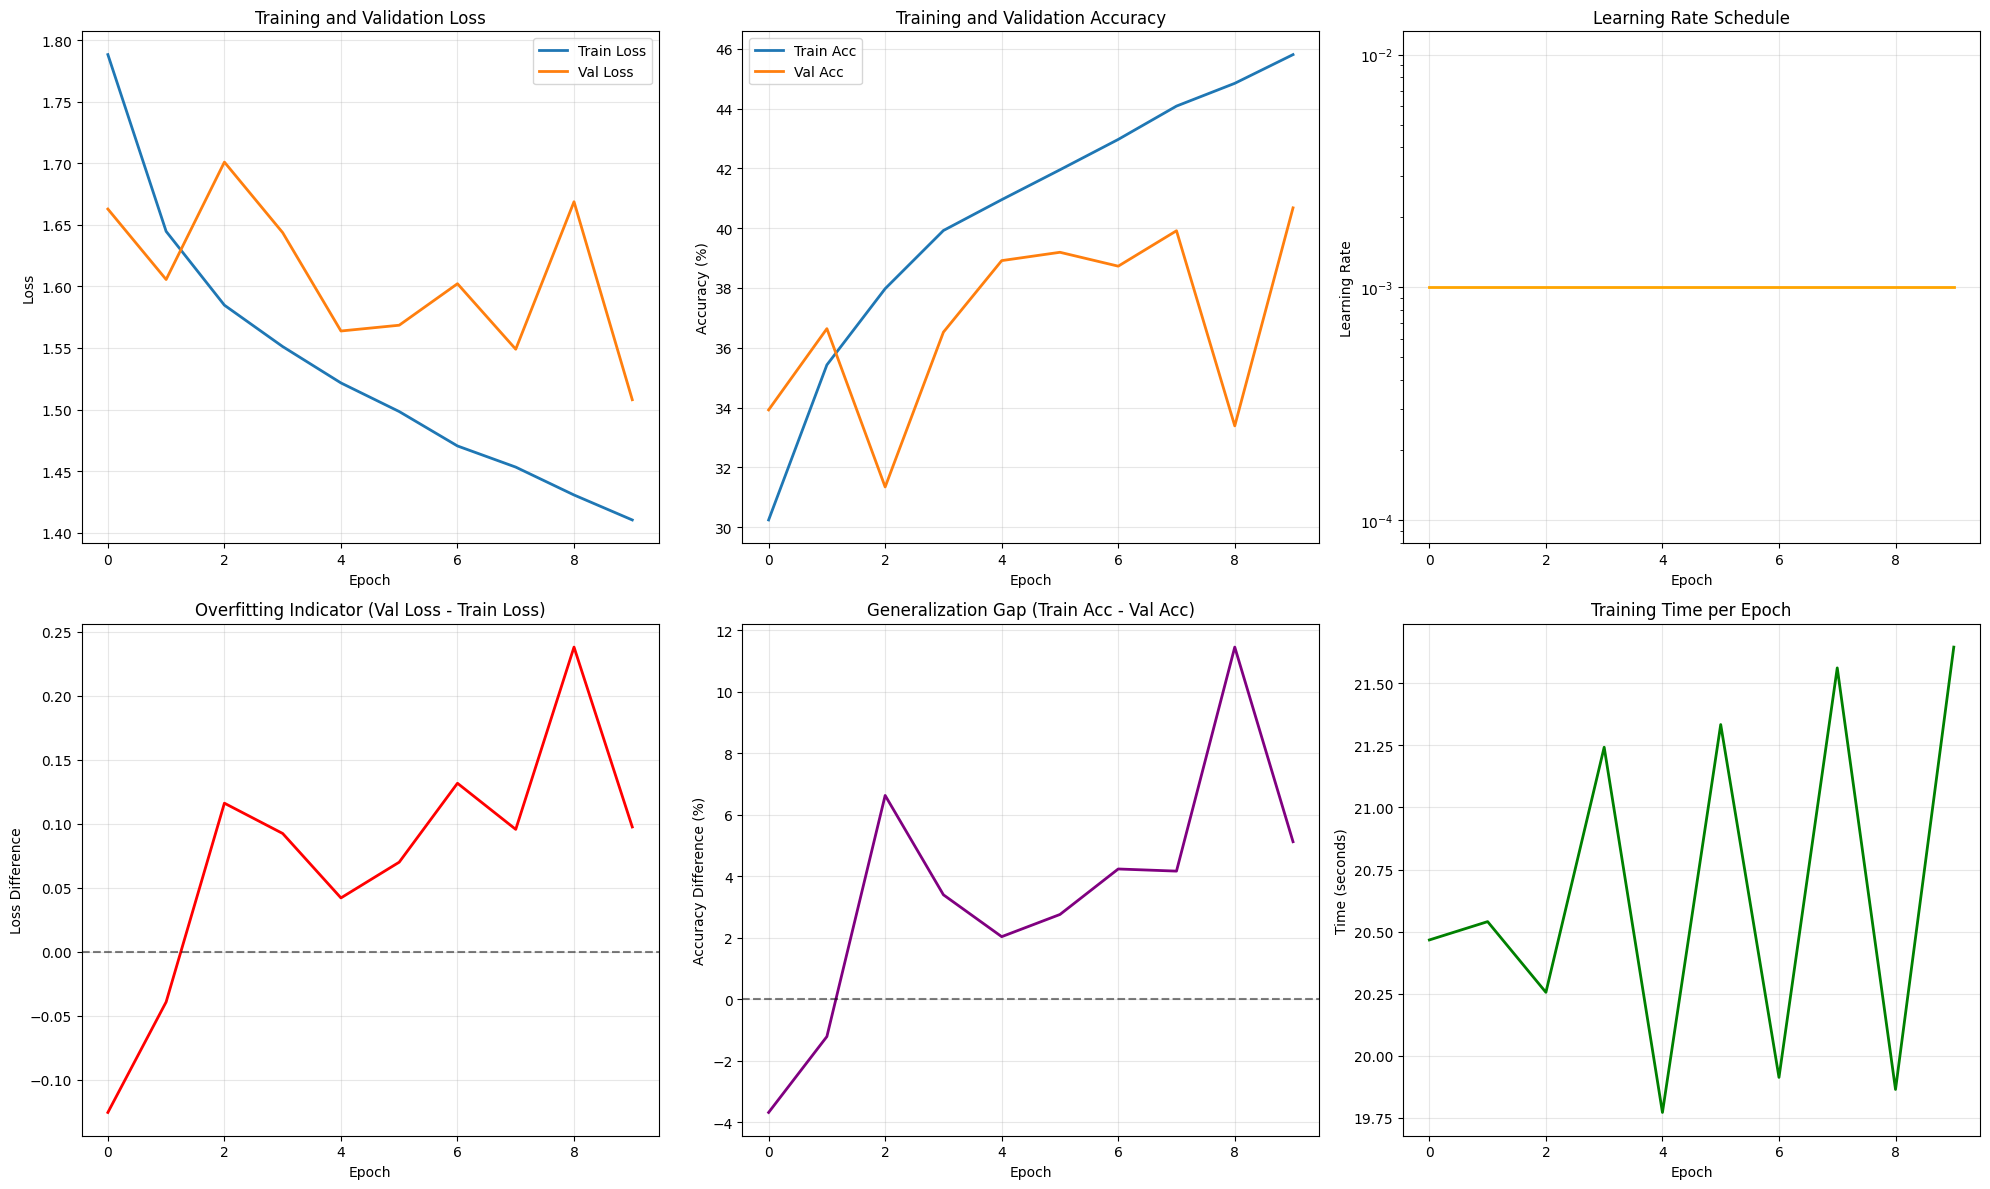


=== OVERFITTING/UNDERFITTING ANALYSIS ===
Final loss gap (val - train): 0.1267
Final accuracy gap (train - val): 5.55%
🔴 UNDERFITTING DETECTED
Recommendations:
  - Increase model complexity
  - Reduce dropout rate
  - Train for more epochs
  - Increase learning rate


In [57]:
print("=== MODEL ANALYSIS ===")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

axes[0, 0].plot(final_history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(final_history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(final_history['train_acc'], label='Train Acc', linewidth=2)
axes[0, 1].plot(final_history['val_acc'], label='Val Acc', linewidth=2)
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(final_history['learning_rates'], linewidth=2, color='orange')
axes[0, 2].set_title('Learning Rate Schedule')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Learning Rate')
axes[0, 2].set_yscale('log')
axes[0, 2].grid(True, alpha=0.3)

loss_gap = np.array(final_history['val_loss']) - np.array(final_history['train_loss'])
axes[1, 0].plot(loss_gap, linewidth=2, color='red')
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Overfitting Indicator (Val Loss - Train Loss)')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss Difference')
axes[1, 0].grid(True, alpha=0.3)

acc_gap = np.array(final_history['train_acc']) - np.array(final_history['val_acc'])
axes[1, 1].plot(acc_gap, linewidth=2, color='purple')
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Generalization Gap (Train Acc - Val Acc)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy Difference (%)')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(final_history['epoch_times'], linewidth=2, color='green')
axes[1, 2].set_title('Training Time per Epoch')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Time (seconds)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('advanced_mlp_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

final_loss_gap = loss_gap[-5:].mean()
final_acc_gap = acc_gap[-5:].mean()

print("\n=== OVERFITTING/UNDERFITTING ANALYSIS ===")
print(f"Final loss gap (val - train): {final_loss_gap:.4f}")
print(f"Final accuracy gap (train - val): {final_acc_gap:.2f}%")

if final_loss_gap > 0.2 and final_acc_gap > 5:
    print("🔴 OVERFITTING DETECTED")
    print("Recommendations:")
    print("  - Increase dropout rate")
    print("  - Add more regularization (L1/L2)")
    print("  - Reduce model complexity")
    print("  - Increase dataset size or augmentation")
elif final_history['val_acc'][-1] < 50:
    print("🔴 UNDERFITTING DETECTED")
    print("Recommendations:")
    print("  - Increase model complexity")
    print("  - Reduce dropout rate")
    print("  - Train for more epochs")
    print("  - Increase learning rate")
else:
    print("✅ GOOD FIT ACHIEVED")
    print("Model shows good generalization performance")

In [61]:
class SavedAdvancedMLP(nn.Module):
    def __init__(self, input_size=2304, hidden_sizes=[1024, 512, 256], num_classes=7,
                 dropout_rate=0.3, use_batch_norm=True):
        super(SavedAdvancedMLP, self).__init__()

        self.flatten = nn.Flatten()

        layers = []
        prev_size = input_size

        # Add all hidden layers WITH batch norm after each
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        # Final output layer (no batch norm after this)
        layers.append(nn.Linear(prev_size, num_classes))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x

In [2]:
print("=== SAVING ADVANCED MLP PIPELINE ===")

class AdvancedMLPPipeline:
    def __init__(self, model_state_dict, model_config, normalization='standard'):
        self.model_config = model_config
        self.normalization = normalization
        self.emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

        # Use AdvancedMLP since that's what we trained
        self.model = SavedAdvancedMLP(**model_config['model_params'])
        self.model.load_state_dict(model_state_dict)
        self.model.eval()

    def preprocess(self, pixels_string):
        pixels = np.array([int(p) for p in pixels_string.split()], dtype=np.float32)

        if self.normalization == 'standard':
            pixels = pixels / 255.0
        elif self.normalization == 'centered':
            pixels = (pixels / 255.0) * 2 - 1

        # Return as 2D tensor since AdvancedMLP has flatten layer
        return torch.FloatTensor(pixels).reshape(1, 48, 48).unsqueeze(0)  # Shape: (1, 1, 48, 48)

    def predict(self, pixels_string):
        with torch.no_grad():
            input_tensor = self.preprocess(pixels_string)
            output = self.model(input_tensor)
            probabilities = torch.softmax(output, dim=1)
            prediction = torch.argmax(output, dim=1)

            return {
                'predicted_class': int(prediction.item()),
                'predicted_emotion': self.emotion_map[int(prediction.item())],
                'confidence': float(probabilities.max().item()),
                'all_probabilities': {
                    self.emotion_map[i]: float(probabilities[0, i].item())
                    for i in range(7)
                }
            }

    def predict_batch(self, pixels_strings):
        batch_tensors = []
        for pixels_string in pixels_strings:
            # Each tensor should be (1, 48, 48) for the batch
            pixels = np.array([int(p) for p in pixels_string.split()], dtype=np.float32)
            if self.normalization == 'standard':
                pixels = pixels / 255.0
            elif self.normalization == 'centered':
                pixels = (pixels / 255.0) * 2 - 1

            tensor = torch.FloatTensor(pixels).reshape(1, 48, 48)
            batch_tensors.append(tensor)

        # Shape: (batch_size, 1, 48, 48)
        batch_input = torch.stack(batch_tensors)

        with torch.no_grad():
            outputs = self.model(batch_input)
            probabilities = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(outputs, dim=1)

            results = []
            for i in range(len(pixels_strings)):
                results.append({
                    'predicted_class': int(predictions[i].item()),
                    'predicted_emotion': self.emotion_map[int(predictions[i].item())],
                    'confidence': float(probabilities[i].max().item()),
                    'all_probabilities': {
                        self.emotion_map[j]: float(probabilities[i, j].item())
                        for j in range(7)
                    }
                })

            return results

model_type = 'advanced'
model_params = {
    'input_size': 2304,
    'hidden_sizes': [1024, 512, 256],
    'num_classes': 7,
    'dropout_rate': 0.3,
    'use_batch_norm': False
}

model_config = {
    'model_type': model_type,
    'model_params': model_params,
    'training_config': {
        'best_activation': best_activation,
        'best_optimizer': best_optimizer,
        'best_batch_norm': best_bn,
        'normalization': 'standard'
    }
}

pipeline = AdvancedMLPPipeline(
    best_model.state_dict(),  # Use best_model, not best_final_model
    model_config,
    normalization='standard'
)

os.makedirs('models/saved_pipelines', exist_ok=True)

torch.save({
    'model_state_dict': best_model.state_dict(),  # Use best_model
    'model_config': model_config,
    'training_history': final_history,  # Use final_history
    'validation_accuracy': final_trainer.best_val_acc,  # Use final_trainer
    'evaluation_metrics': {
        'accuracy': accuracy,
        'per_class_f1': f1.tolist(),
        'mean_f1': float(np.mean(f1)),
        'confusion_matrix': cm.tolist()
    },
    'experiment_results': {
        'activation_results': activation_results,
        'optimizer_results': optimizer_results,
        'scheduler_results': scheduler_results,
        'batch_norm_results': bn_results
    },
    'data_split_info': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'split_method': 'predefined_stratified'
    }
}, 'models/saved_pipelines/advanced_mlp_pipeline.pth')

print("✅ Advanced MLP pipeline saved successfully!")

test_sample = val_df.iloc[0]['pixels']
test_prediction = pipeline.predict(test_sample)
print(f"\nPipeline test:")
print(f"Predicted emotion: {test_prediction['predicted_emotion']}")
print(f"Confidence: {test_prediction['confidence']:.4f}")

# Also update the final summary to use correct variables
print(f"\n📊 FINAL RESULTS SUMMARY:")
print(f"🥇 Best Configuration:")
print(f"   Activation: {best_activation}")
print(f"   Optimizer: {best_optimizer}")
print(f"   Scheduler: {best_scheduler}")
print(f"   Batch Norm: {best_bn}")
print(f"   Model Type: {model_type}")
print(f"📈 Performance:")
print(f"   Validation Accuracy: {final_trainer.best_val_acc:.2f}%")  # Use final_trainer
print(f"   Mean F1 Score: {np.mean(f1):.4f}")
print(f"💾 Model saved to: models/saved_pipelines/advanced_mlp_pipeline.pth")

=== SAVING ADVANCED MLP PIPELINE ===


NameError: name 'best_activation' is not defined